<a href="https://colab.research.google.com/github/jkworldchampion/Military_CodingStudy/blob/main/deeplearning/A_hour_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 간단한 코드로 gan의 구조 살펴보기
다음은 Gan의 핵심인 Discriminator와 Generator가 어떻게 구성되어 있는지 가볍게 알아볼 수 있는 코드이다.

In [ ]:
import torch
import torch.nn as nn

# 판별기 생성
D = nn.Sequential(
    nn.Linear(784, 128),   # 입력 28*28, hidden 128
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid()
)

# 생성기 생성
G = nn.Sequential(
    nn.Linear(100, 128),
    nn.ReLU(),
    nn.Linear(128, 784),
    nn.Tanh()
)

# loss함수 정의
criterion = nn.BCELoss()

# optimizer 설정
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.01)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.01)

# 입력값에 대한 가정
# Assume x be real images of shape (batch_size, 784)
# Asuume z be random nois of shape (batch_size, 100)

# train
while True:
    # train D
    loss = criterion(D(x), 1) + criterion(D(G(z)), 0)
    loss.backward()
    d_optimizer.step()

    # train G
    loss = criterion(D(G(z)), 1)
    loss.backward()
    g_optimizer.step()

# 실행이 되는 gan코드!!

## 필요 library 불러오기

In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image

## Gpu 설정과 Hyper-parameter 설정해주기

In [ ]:
# Device configuration
# torch.device('cuda') or ('cpu')로 device설정
# torch.cuda.is_available()로 cuda 가능한지 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # cuda.is

# Hyper-parameters
latent_size = 64   # 생성기 G를 최적화시키기 위해 적절하게 큰 latent space의 크기를 결정하는 값. 결국 가장 중요한 값.
hidden_size = 256  
image_size = 784   # input의 28*28
num_epochs = 200
batch_size = 100
sample_dir = 'samples'

## Data 불러오기(다운로드) 및 기본 설정

In [ ]:
# Create a directory if not exists
if not os.path.exists(sample_dir):  # 현재 경로에 samples 파일이 없으면
    os.makedirs(sample_dir)         # samples 파일을 만들어라

# Image processing
transform = transforms.Compose([  
    transforms.ToTensor(),             # numpy 이미지에서 torch 이미지로 변경
    transforms.Normalize(mean=[0.5],   # 1 for greyscale channels
                         std=[0.5])    # normailze는 (image - mean / std)를 수행함. 즉, 정규화 시키기
])

# MNIST dataset
mnist = torchvision.datasets.MNIST(root='/data',   # 경로 설정
                                   train=True,     # train용 데이터를 가져올지, test용인지. True일 경우 train용 데이터
                                   transform=transform,  # 이미지를 가져올 형태
                                   download=True)  # mnist가 없으면 다운로드 한다

data_loader = torch.utils.data.DataLoader(dataset=mnist,  # 어떤 데이터를 가져오는가
                                          batch_size=batch_size,  # batch_size
                                          shuffle=True)   # 섞을것인지

tensor(3)


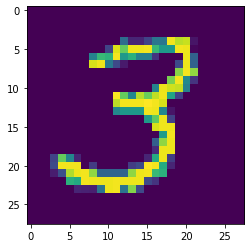

In [ ]:
# data_loader에서 간단하게 데이터 살펴보기
import matplotlib.pyplot as plt
for data in data_loader:
  now_image = data[0][0]
  tran = transforms.ToPILImage()
  img_t = tran(now_image)
  plt.imshow(img_t)
  print(data[1][0])
  break

## Discriminator와 Generator build

In [ ]:
# Discriminator   
'''
D는 판별기로써 결국 진짜를 1로, 가짜를 0으로 판별해야함 결과치는 softmax이므로 0~1에 해당함 
'''
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid()
)

# Generator
'''
G는 생성기로써 진짜같은 이미지를 생성해 내야함, 즉 D(G(x)) = 1로 가까워져야함.
'''
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh()
)

# Device setting  
D = D.to(device)   # Gpu로 설정
G = G.to(device)

## Loss function설정과 Optimizer 설정

In [ ]:
# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)     # D:G를 1:5정도로 해봤는데 매우 망했다.

# 사진 저장시 필요한 denormalization function
def denorm(x):     
    out = (x+1) / 2
    return out.clamp(0, 1)   

# iteration마다 gradient를 초기화 해주기 위한 function
def reset_grad():
    d_optimizer.zero_grad()   # pytorch는 gradient가 누적되기 때문에 다시 0으로 만들어 줘야한다.
    g_optimizer.zero_grad()

## 학습하기와 결과물 저장하기

In [ ]:
# Start training
total_step = len(data_loader)  # 600
for epoch in range(num_epochs):  # 주어진 epochs만큼 돌리기
    for i, (images, _) in enumerate(data_loader):  # data_loader에서 iterator 객체를 받아와 하나씩 다룬다. 정확히는 batch_size만큼 matrix로 가져온다, 정답에 해당하는 tensor배열은 _로 버린다
        images = images.reshape(batch_size, -1).to(device)   # (100, 1, 28, 28) -> (100, 784)

        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size, 1).to(device)    # (100, 1)의 1로된 tensor / 결국 D가 진짜 이미지를 1로 판별해야하기 때문
        fake_labels = torch.zeros(batch_size, 1).to(device)   # (100, 1)의 0으로 된 tensor

        #===========================#
        #  Train the discriminator  # 
        #===========================#

        # Compute BCE_Loss using real images where BCE_Loss(x, y): -y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_label == 1
        outputs = D(images)                             # outputs.shape = (batch_size, 1), 각각 진짜일 sigmoid값 
        d_loss_real = criterion(outputs, real_labels)   # 진짜일 확률을 예측한 값과 1 사이의 Binary_Cross_Entropy값 0.67
        real_score = outputs

        # Compute BCELoss using fake images
        # First term of the loss is always zero since fake_labels == 0
        z = torch.randn(batch_size, latent_size).to(device)   # latent_size를 통해 잠재 공간의 크기를 정한 뒤 이미지에서 특징을 매칭시킬 z를 정의한다.
        fake_images = G(z)                                    # z를 통해 fake_image를 생성한다  
        
        # 생성된 이미지를 볼 수 있다!!
        # tran = transforms.ToPILImage()
        # img_t = tran(fake_images[0].reshape(28,28))
        # plt.imshow(img_t)

        outputs = D(fake_images)   # fake_image에 대한 진실 판별값을 알아본다
        d_loss_fake = criterion(outputs, fake_labels)  # BCELoss를 구한다
        fake_score = outputs
        
        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        reset_grad()  
        d_loss.backward()   # 스칼라 값에 대해 미분을 시행한다
        d_optimizer.step()  # 미분값을 토대로 parameters를 갱신한다
        
        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        # Compute loss with fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)   # D(G(z))
        
        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = criterion(outputs, real_labels)    # 결국 D(G(z))가 1로 가까워져야하기 때문
        
        # Backprop and optimize
        reset_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if (i+1) % 300 == 0:    # batch_size에 의해 iterator가 3번 돌면, 즉 데이터가 반이 계산되면 다음을 출력
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
    
    # Save real images
    if (epoch+1) == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))
    
    # Save sampled images
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))

## 모델 저장하기

In [ ]:
# Save the model checkpoints 
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

가볍진 않지만 epochs 200 정도 돌린 결과물은 다음과 같다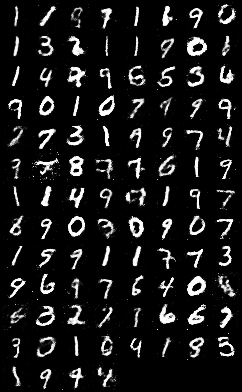